# E-commerce Fraud Detection Analysis

### Load libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  roc_auc_score, roc_curve
from sklearn.externals import joblib 

from skopt import BayesSearchCV

from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
from imblearn.pipeline import Pipeline # doctest: +NORMALIZE_WHITESPACE

%matplotlib inline

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


### Load data

Random Forest are used on cleanXG_LR.zip dataset. This data set have 2 type of data X1 and X2 with following specifications:
- General - Preprocessing applied to all files:
    - Features with > 90% data missing or > 90% data with the same value were dropped
    - If possible, categorical variables with 100s of categories were mapped to coaser categoricals
    - Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity
        - https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
    - Some "D" columns were normalized for time
    - Aggregate features were added using "magic" technique
        - https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works
    - Dropped TransactionID and TransactionDT

- XGBoost_LR_{train, test}_X_1.pkl ==> 1323 features
    - Full 200 features
	- Dummies created
    - NAs filled with -999
- XGBoost_LR_{train, test}_X_2.pkl ==> 1303 features
    - Removed additional features:
        - Highly correlated "C", "D" features
        - Removed features Chris (1st place winners) removed
        - Removed caterogical features withh 200+ categories even after 1)
    - Dummies created
    - NAs filled with -999


In [2]:
#Load train y data
y = pd.read_pickle("data/train_y.pkl")


In [3]:
#Load train x data
X = pd.read_pickle("data/cleanXG_LR/XGBoost_LR_train_X_1.pkl")

# Replace Nan (currently -999 in the input dataset) with 0:
X = X.replace(-999, 0)

In [4]:
y.shape, X.shape

((590540,), (590540, 1323))

In [5]:
X.head(3)

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,...,DeviceInfo_za409,DeviceInfo_za509,DeviceInfo_za990,DeviceInfo_zeia8,DeviceInfo_zte,DeviceInfo_zte a2017u build/nrd90m,DeviceInfo_zte-z835,DeviceInfo_zte-z956,DeviceInfo_zur70016,DeviceInfo_zuum_zen_i build/lrx21m
0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,49.0,...,0,0,0,0,0,0,0,0,0,0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,52.0,...,0,0,0,0,0,0,0,0,0,0


### Random Forest - Base Model (Optional?)

### Random Forest - 2 nested train-test split

### Split training data into training (A) and validation (B)

In [6]:
# Specify parameters
seed = 123
test_size = 0.3 #Testing percentage in train/test split

In [ ]:
# Get a subset of data for debugging (PLEASE SKIP THIS ON ACTUAL RUN)
X = X.iloc[:10000,:]
y = y.iloc[:10000]

In [8]:
# Outer validation for model family comparison: slipt data into training (A) and testing (B)
X_A, X_B, y_A, y_B = train_test_split(X, y, test_size = test_size, random_state = seed)

# Reset all indices
X_A.reset_index(drop = True, inplace = True)
X_B.reset_index(drop = True, inplace = True)
y_A.reset_index(drop = True, inplace = True)
y_B.reset_index(drop = True, inplace = True)

### Part A: Parameter tuning on training data (A)

In [ ]:
# Inner validation for parameter tuning within a model family: split data into training (C) and testing (D)
# Set up train-test split validation
A_ind = np.arange(len(X_A))
C_ind, D_ind = train_test_split(A_ind, test_size = test_size, random_state = seed)

X_C = X_A.iloc[C_ind,:]
y_C = y_A.iloc[C_ind]


# Reformat index array to 2D list to be used within "cv" context:
# Desired format: [ ( [train_ind_fold1], [test_ind_fold1]) , ([train_ind_fold2], [test_ind_fold2]) ]
C_ind = list(C_ind) #Train
D_ind = list(D_ind) #Test
cv = [(C_ind, D_ind)] #(Train indices, Test indices)
#list(cv)

In [ ]:
#Get numeric features that need to be scaled to mean 0 and unit variance and unimodal variables to exclude 
#unimode_list = []
binary_list = []
thres = 5 #5% of feature value is 1
for colname in X_C.columns:
    if len(np.unique(X_C[colname])) == 2:
        binary_list.append(colname)
        #percent_1 = np.sum(X[colname])/len(X[colname])*100

        #if percent_1 < thres:
        #    unimode_list.append(colname)

#print("There are %d/%d features that have almost same value btw fraud vs non-fraud" %(len(unimode_list), len(X.columns)))
print('There are %d/%d features that have binary (2) levels {0,1}' %(len(binary_list), X_C.shape[1]))
    

#List of multivariate numeric features: (Note: We do not scale binary features (values  = {0,1})) 
numeric_features = list(set(X_C.columns.to_list()) - set(binary_list))
print('There are %d/%d numeric features that needs to be scaled' %(len(numeric_features), X_C.shape[1]))

In [ ]:
#Build pipeline to include preprocessing step of scaling multivariate numeric features.
numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

preprocessor = ColumnTransformer([
        ('numericals', numeric_transformer, numeric_features)
    ])


pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('clf', RandomForestClassifier(class_weight = 'balanced', random_state = seed))
    ])


In [ ]:
#Set up search space for parameter
params = {   
        'clf__n_estimators': (100,200),
        'clf__max_depth': (20, 25),
        'clf__max_features': ('auto', 'log2', 'sqrt')
    }


In [ ]:
rf_tuner = BayesSearchCV(estimator = pipeline, search_spaces = params, scoring = 'roc_auc',\
                          cv = cv, n_jobs = 3, n_iter = 5, verbose = 1, refit = True, random_state = seed)

In [ ]:
def status_print(optim_result):    
    all_models = pd.DataFrame(rf_tuner.cv_results_)    
    
    # Get best parameters    
    best_params = pd.Series(rf_tuner.best_params_)
    print(f'Model {len(all_models)}:\nBest ROC-AUC:\
    {np.round(rf_tuner.best_score_, 4)}\nBestparams:{rf_tuner.best_params_}\n')
    
    # Save to csv
    #clf_name = rg_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
print('Modeling..')
best_rf = rf_tuner.fit(X_A, y_A, callback = status_print)

In [ ]:
best_rf.cv_results_ #Note each split is an iteration. No. splits = no. iterations

In [ ]:
best_rf.best_params_

### Part B: Retrain model on entire training data (A) and apply on validation data (B)

##### Build Model

In [9]:
# Proprocess data on A - feature scaling

# Step 1: get list of feature to scale
# Numeric features are those that have more than 2 levels.
# We will scale these features to have mean 0 and unit variance and unimodal variables to exclude 

numeric_features = []
thres = 5 #5% of feature value is 1
for colname in X_A.columns:
    if len(np.unique(X_A[colname])) > 2:
        numeric_features.append(colname)

print('There are %d/%d numeric features that needs to be scaled' %(len(numeric_features), X_A.shape[1]))

# Step 2: train scaler using training data (A) only
scaler = StandardScaler().fit(X_A[numeric_features])
    
# Step 3: apply scaler on  training data (A) and testing data (B)
X_A.loc[:,numeric_features] = scaler.transform(X_A.loc[:,numeric_features])
X_B.loc[:,numeric_features] = scaler.transform(X_B.loc[:,numeric_features])

# Sanity check:
rand_ind_check = np.random.randint(len(numeric_features))
print('mean = 0 and variance = 1')
print(np.mean(X_A.loc[:,numeric_features[rand_ind_check]]), np.std(X_A.loc[:,numeric_features[rand_ind_check]])**2)

There are 169/1323 numeric features that needs to be scaled


C:\Users\MyPC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\MyPC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


mean = 0 and variance = 1
-6.318563389087296e-17 1.0000000000001137


In [10]:
X_A.head(2)

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,...,DeviceInfo_za409,DeviceInfo_za509,DeviceInfo_za990,DeviceInfo_zeia8,DeviceInfo_zte,DeviceInfo_zte a2017u build/nrd90m,DeviceInfo_zte-z835,DeviceInfo_zte-z956,DeviceInfo_zur70016,DeviceInfo_zuum_zen_i build/lrx21m
0,0.298235,-0.386110,-0.03446,0.02809,-0.142724,0.183549,-0.033623,0.038349,-0.558981,-0.504527,...,0,0,0,0,0,0,0,0,0,0
1,-2.716796,4.557754,-0.03446,0.02809,0.242032,-1.964258,-0.033623,0.038349,1.794596,1.107012,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_B.head(2)

0    0
1    0
Name: isFraud, dtype: int64

In [11]:
# Build model using best hyperparameters found and all training data (A)
rf = RandomForestClassifier(
                             max_depth = best_rf.best_params_['clf__max_depth'],
                             max_features = best_rf.best_params_['clf__max_features'],
                             n_estimators = best_rf.best_params_['clf__n_estimators'],
                             class_weight = 'balanced',
                             random_state = seed)
rf.fit(X_A, y_A)


NameError: name 'best_rf' is not defined

In [14]:
# Get tuned parameter from colab
# Build model using best hyperparameters found and all training data (A)
rf = RandomForestClassifier(
                             max_depth = 32,
                             max_features = 'log2',
                             n_estimators = 931,
                             class_weight = 'balanced',
                             random_state = seed)
rf.fit(X_A, y_A)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=32, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=931,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

##### Feature Importance

In [20]:
feature_imp = pd.DataFrame(zip(rf.feature_importances_,X_A.columns), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by = ['Value'], ascending = False).reset_index(drop = True)
feature_imp.head(10)

,Value,Feature
0,0.015553,D1
1,0.015164,C13
2,0.014276,TransactionAmt_card1_mean
3,0.014041,C14
4,0.013931,TransactionAmt_card1_std
5,0.013663,TransactionAmt_card1_addr1_mean
6,0.013584,TransactionAmt_card1_addr1_P_emaildomain_mean
7,0.012882,TransactionAmt
8,0.012779,V307
9,0.012536,D15


##### Test model and report performance metrics

In [22]:
# Apply model on testing data (B)
y_B_pred_labels = rf.predict(X_B)

0.9545732773342136


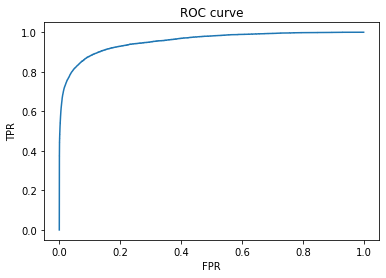

In [28]:
# Get probability of class 1 on testing data (B) and report performance metrics:
y_B_pred_prob = rf.predict_proba(X_B)[:,1]

print(roc_auc_score(y_B, y_B_pred_prob))

fpr, tpr, _ = roc_curve(y_B, y_B_pred_prob)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

Confusion Matrix (Note: this result is not a good representation as it assumes 2 classes weight the same)


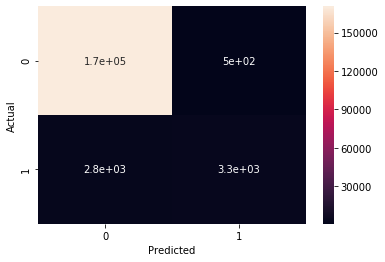

In [29]:
print('Confusion Matrix (Note: this result is not a good representation as it assumes 2 classes weight the same)')


data = {'y_Actual':    list(y_B),
        'y_Predicted': list(y_B_pred_labels)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sb.heatmap(confusion_matrix, annot=True)
plt.show()

In [30]:
y_B_pred_prob

array([0.02504309, 0.02669005, 0.75633608, ..., 0.12943162, 0.02744362,
       0.08152453])

## Part C: Save Deliverables
We will save the following deliverables:
- Model [pkl format]
- Predicted Probability of validation data (B) [dataframe format]
- Feature Importance [dataframe format]
- ROC curve [png]
- Feature Importance [png]

ROC-AUC Score = 0.9545732773342136


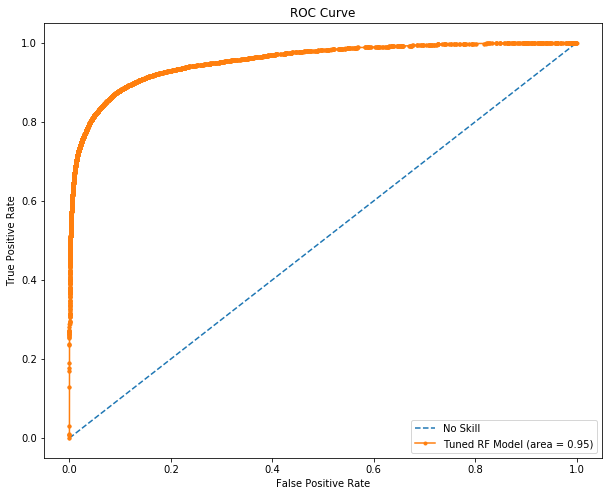

In [31]:
# Plot ROC-AUC Curve and save
rf_frp, rf_tpr, _ = roc_curve(y_B, y_B_pred_prob)
AUC_score = roc_auc_score(y_B, y_B_pred_prob)
print('ROC-AUC Score =', AUC_score)

# Define true-positive and false-positive for no skill predictions
no_skill_pred = [0 for _ in range(len(y_B))]
ns_frp, ns_tpr, _ = roc_curve(y_B, no_skill_pred)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
plt.plot(rf_frp, rf_tpr, marker = '.', label='Tuned RF Model (area = %0.2f)' % AUC_score)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.legend(loc="lower right")
plt.savefig('Random Forest ROC Curve.png')
plt.show()

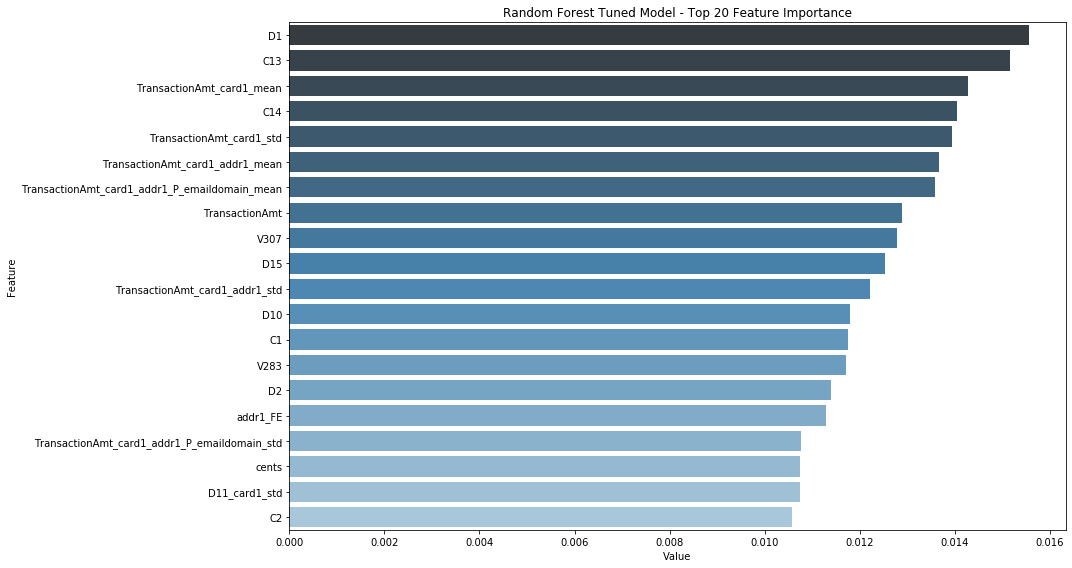

Wall time: 832 ms


In [32]:
%%time
# Plot feature importance and save figure
plt.figure(figsize=(15, 8))
sb.barplot(x="Value", y="Feature", data=feature_imp.iloc[:20], palette = "Blues_d")
plt.title('Random Forest Tuned Model - Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('Random Forest Feature Importance.png')
plt.show()

In [34]:
# Save predicted data:
# 1) Model// To load model: rf_tuned = joblib.load('TunedRandomForest.pkl') 
joblib.dump(rf, 'TunedRandomForest.pkl') 

# 2) Dataframe data// To load data: feature_imp = pd.read_pickle("RF_feature_importance.pkl")
feature_imp.to_pickle("RF_feature_importance.pkl")

# 3) Numpy data// To load data: y_B_pred_prob = np.load('RF_y_B_pred_prob.npy') 
validation_results = pd.DataFrame(zip(y_B, y_B_pred_prob), columns=['True Label','Predicted Label'])
validation_results.to_pickle("RF_validation_results.pkl")
validation_results.head()

In [35]:
validation_results.head()

,True Label,Predicted Label
0,0,0.025043
1,0,0.026690
2,1,0.756336
3,0,0.082933
4,0,0.056339
